In [69]:
import numpy as np
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA, ARIMA
from model_builder import stationarity_test
from criteria_housing import name_zipcode_area
from matplotlib import pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [144]:
#loading all zipcodes pandas dataframes
zillow_df = pd.read_csv('../write_data/zipcodes_all_price.csv',
                        index_col = 0, parse_dates = True)
zillow_df.columns = pd.to_numeric(zillow_df.columns)

# loading top 100 ROI zipcodes pandas dataframes
top_df = pd.read_csv('../write_data/top_monthly.csv', 
                     index_col = 0, parse_dates = True)
top_df.columns = pd.to_numeric(top_df.columns)

# loading bottom 100 ROI zipcodes pandas dataframes
bottom_df = pd.read_csv('../write_data/bottom_monthly.csv', 
                        index_col = 0, parse_dates = True)
bottom_df.columns = pd.to_numeric(bottom_df.columns)

# loading random 100 ROI zipcodes pandas dataframes
random_df = pd.read_csv('../write_data/random_monthly.csv', 
                        index_col = 0, parse_dates = True)
random_df.columns = pd.to_numeric(random_df.columns)

In [143]:
zillow_df.head()

,60657,75070,77494,60614,79936,77084,10467,60640,77449,94109,...,3765,84781,12429,97028,12720,1338,3293,40404,81225,89155
Date_index,,,,,,,,,,,,,,,,,,,,,
1996-04-01,334200.0,235700.0,210400.0,498100.0,77300.0,95000.0,152900.0,216500.0,95400.0,766000.0,...,80800.0,135900.0,78300.0,136200.0,62500.0,94600.0,92700.0,57100.0,191100.0,176400.0
1996-05-01,335400.0,236900.0,212200.0,500900.0,77300.0,95200.0,152700.0,216700.0,95600.0,771100.0,...,80100.0,136300.0,78300.0,136600.0,62600.0,94300.0,92500.0,57300.0,192400.0,176300.0
1996-06-01,336500.0,236700.0,212200.0,503100.0,77300.0,95400.0,152600.0,216900.0,95800.0,776500.0,...,79400.0,136600.0,78200.0,136800.0,62700.0,94000.0,92400.0,57500.0,193700.0,176100.0
1996-07-01,337600.0,235400.0,210700.0,504600.0,77300.0,95700.0,152400.0,217000.0,96100.0,781900.0,...,78600.0,136900.0,78200.0,136800.0,62700.0,93700.0,92200.0,57700.0,195000.0,176000.0
1996-08-01,338500.0,233300.0,208300.0,505500.0,77400.0,95900.0,152300.0,217100.0,96400.0,787300.0,...,77900.0,137100.0,78100.0,136700.0,62700.0,93400.0,92100.0,58000.0,196300.0,175900.0


In [34]:
#Selecting top, bottom and five ROI zipcodes
topfive_zipcodes = top_df.columns[:5]
topfive_df = top_df[topfive_zipcodes]

bottomfive_zipcodes = bottom_df.columns[-5:]
bottomfive_df = bottom_df[bottomfive_zipcodes]

randomfive_zipcodes = random_df.columns[:5]
randomfive_df = random_df[randomfive_zipcodes]

In [46]:
topfive_df.head()

,7106,29661,64110,20621,7103
Date_index,,,,,
1996-04-01,91400.0,56500.0,59200.0,94300.0,78000.0
1996-05-01,91300.0,56800.0,59500.0,95200.0,78100.0
1996-06-01,91200.0,57200.0,59700.0,96000.0,78200.0
1996-07-01,91200.0,57600.0,59900.0,96900.0,78300.0
1996-08-01,91200.0,58000.0,60200.0,97700.0,78300.0


In [36]:
#loading state, county and region details for our data
region_df = pd.read_csv('../write_data/regions_zipcode.csv', index_col=0)

name_zipcode_area(region_df, topfive_zipcodes)

,RegionID,RegionName,City,State,Metro,CountyName
4211,60610,7106,Newark,NJ,New York,Essex
10069,70641,29661,Marietta,SC,Greenville,Greenville
6216,86349,64110,Kansas City,MO,Kansas City,Jackson
14244,66512,20621,Chaptico,MD,California-Lexington Park,Saint Marys
3540,60607,7103,Newark,NJ,New York,Essex


* **Checking for stationarity of data before building models**

In [ ]:
zillow

In [37]:
##adfuller stationarity test on topfive_df
stationarity_test(topfive_df, 'diff()')

[(7106, 1, 0.0),
 (29661, 1, 0.0),
 (64110, 1, 0.0),
 (20621, 1, 0.0),
 (7103, 1, 0.0)]

In [38]:
##adfuller stationarity test on bottomfive_df
stationarity_test(bottomfive_df, 'diff()')

[(71238, 1, 0.0),
 (10128, 1, 0.0),
 (11222, 1, 0.0),
 (16625, 1, 0.0),
 (70090, 1, 5.8212270740707495e-30)]

In [39]:
##adfuller stationarity test on randomfive_df
stationarity_test(randomfive_df, 'diff()')

[(21029, 1, 0.0),
 (91403, 1, 0.0),
 (68005, 1, 0.0),
 (85028, 1, 0.0),
 (65550, 1, 2.331654935886499e-30)]

* **Finding autoregressive order p using autocorrelation**

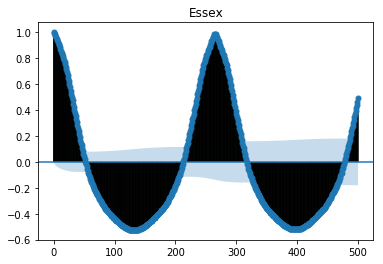

In [73]:
## value greater than 
plot_acf(topfive_df[7106], lags=500, alpha=0.05, title = 'Essex')
plt.show()
# for col in topfive_df:
#     plot_acf(topfive_df[col], lags=50, alpha=0.05, title=f'{col}')

* **This sequence is repeating every twenty years**

In [76]:
#auto correlation function. A value greater than 0.05 is a viable AR order p
acf(topfive_df[7106], nlags=50)

array([1.        , 0.99324043, 0.98441982, 0.9742717 , 0.96320004,
       0.95129874, 0.93866163, 0.92554799, 0.9120326 , 0.89830622,
       0.88445702, 0.87059132, 0.85689951, 0.84352079, 0.83006641,
       0.81611242, 0.80144935, 0.78609997, 0.76993182, 0.75277352,
       0.73449611, 0.71478854, 0.69358117, 0.67120172, 0.64798619,
       0.62397142, 0.59929662, 0.57437719, 0.54950846, 0.52453367,
       0.49936753, 0.47423061, 0.44918389, 0.42434404, 0.39985428,
       0.37582555, 0.3522558 , 0.32917878, 0.30656275, 0.28416973,
       0.26188109, 0.23965167, 0.21724504, 0.1945141 , 0.17172762,
       0.14925694, 0.12728104, 0.10568035, 0.08423087, 0.06294148,
       0.04198906])

* **Finding moving average order q using partial autocorrelation**

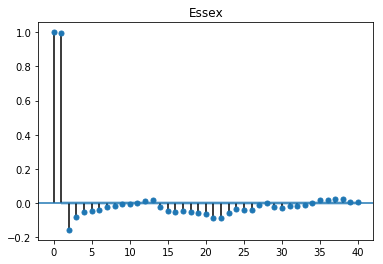

In [89]:
#partial autocorrelation function. A value greater than 0.05 is a viable MA order q
plot_pacf(topfive_df[7106], lags=40, alpha=0.05, title = 'Essex');

* **since the diff() made the data stationary, the integrated d is 1.**

In [137]:
lowest_num = None
lis = [7, 6, 5, 3, 4, 2]
for i in lis:
    if lowest_num is None:
        lowest_num=i
    elif lowest_num > i:
        lowest_num=i
    else:
        print(lowest_num)


3


In [101]:
# bic_list = []
# bic_lowest = None 
# for p in range(1,5):
#     for q in range(1,5):
#         test_model = ARMA(topfive_df[7106].diff().dropna().values, (p,q)).fit()
#         test_bic = test_model.bic
#         bic_list.append((test_bic, p, q))

In [174]:
stationary_7106_df = pd.DataFrame(zillow_df[7106].diff().values, columns = ['7106_actual'])
stationary_7106_df.head()

,7106_actual
0,NaN
1,-100.0
2,-100.0
3,0.0
4,0.0


In [155]:
bic_list = []
lowest_bic = None
p_value = []
for p in range(1,20):
    for q in range(1,5):
        test_model = ARMA(stationarydata, (p,1)).fit()
        test_bic = test_model.bic

        if lowest_bic is None:
            lowest_bic=test_bic
        elif lowest_bic > test_bic:
            lowest_bic=test_bic
        else:
            print((lowest_bic, p, q))
        break 

(539063.4660622405, 4, 1)
(539063.4660622405, 5, 1)
(539063.4660622405, 6, 1)
(539063.4660622405, 7, 1)


KeyboardInterrupt: 

In [150]:
bic_list

[(539114.021133556, 1),
 (539084.8699659798, 2),
 (539063.4660622405, 3),
 (539070.1887390041, 4)]

In [ ]:
model.plot_predict(1, 300)
plt.xlabel('Number of months')
plt.ylabel('Percentage return')
plt.show()

In [ ]:
model_two_df = zillow_cleandf[[94027, 90210, 94301, 33480, 94123]]
model_two_df.head()

In [ ]:
np.log(model_two_df).plot()
plt.ylabel('log_price');

In [ ]:
from model_builder import stationarity_test

In [ ]:
stationarity_test(model_two_df,'pct_change()')

In [ ]:
model_two = ARMA(model_two_df[94301].pct_change().dropna().values, (2,1)).fit()

In [ ]:
model_two.plot_predict(1, 300)
plt.xlabel('Number of months')
plt.ylabel('price difference every two months')
plt.show()